In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='C:/Users/meika/Desktop/Temp/zhkcsj/code/simsun.ttc')#导入字体
plt.rcParams['figure.figsize'] = [16, 10]

In [3]:
train = pd.read_csv('C:/Users/meika/Desktop/Temp/zhkcsj/data/train/train.csv')
test = pd.read_csv('C:/Users/meika/Desktop/Temp/zhkcsj/data/test/test.csv')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### 平均值+-2倍的标准差（处理时间异常值）

In [7]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

### 处理经纬度异常值（根据纽约边界点 纬度(40.63, 40.85) 经度(-74.03, -73.75)）

In [8]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### 转变日期格式

In [9]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


In [10]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30


## 2通过可视化，观察test和train是否相似的

###### 1.乘车次数日期折线图

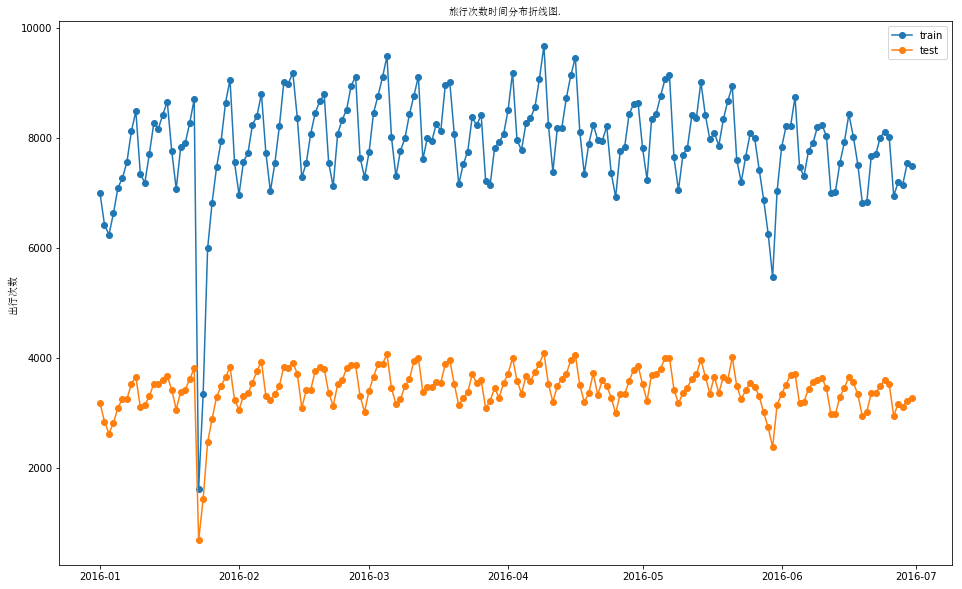

In [11]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('旅行次数时间分布折线图.',fontproperties=myfont)
plt.legend(loc=0)
plt.ylabel('出行次数',fontproperties=myfont)
plt.show()

###### 结论：1-2月和6月出现大幅度下降

###### 乘车时长分布

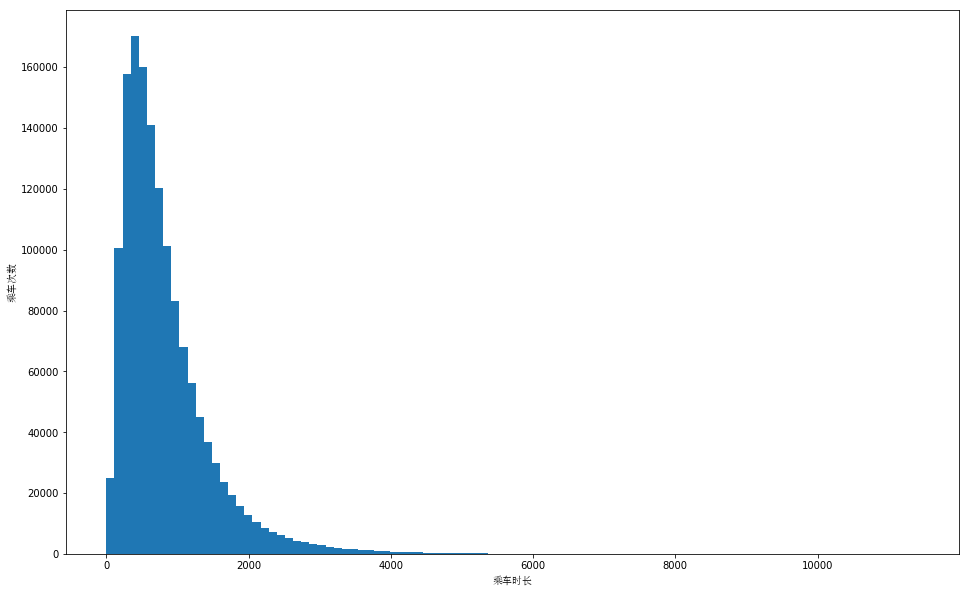

In [12]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('乘车时长',fontproperties = myfont)
plt.ylabel('乘车次数',fontproperties = myfont)
plt.show()

###### 取对数使数据更直观

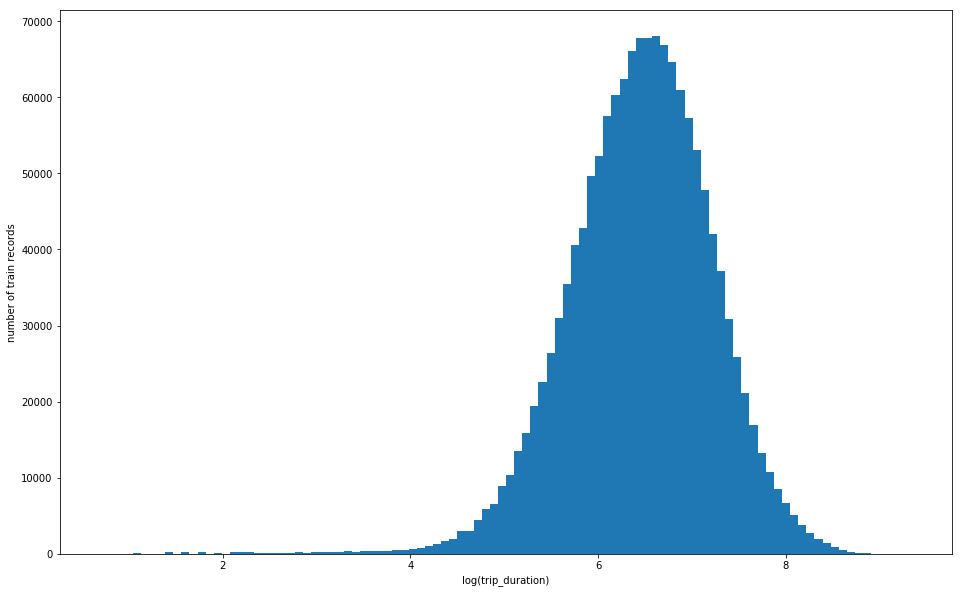

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


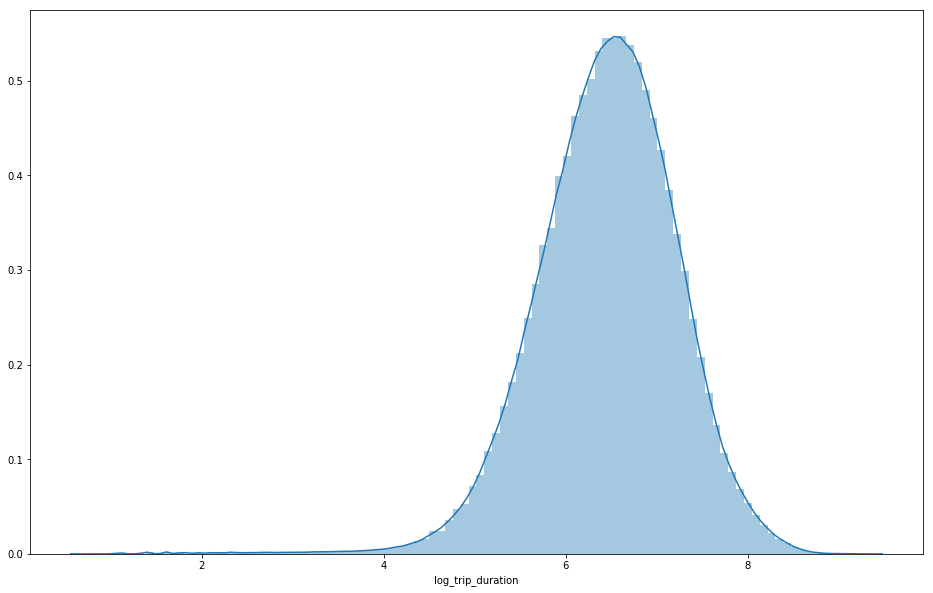

In [13]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

###### 统计每家公司，平均运行周期（时长）

No handles with labels found to put in legend.


Text(0,0.5,'Time in Seconds')

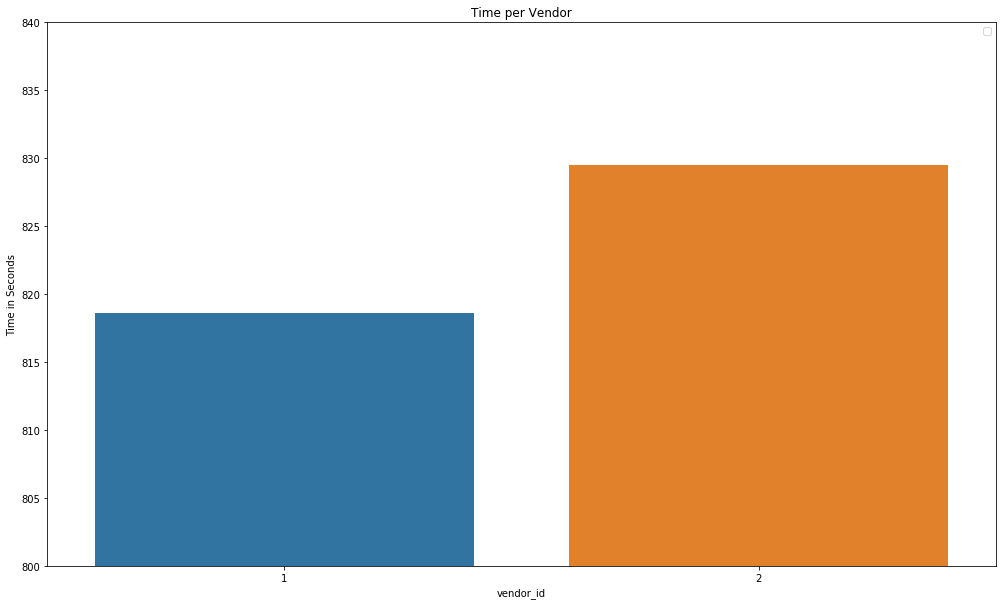

In [14]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

###### 行程是否之前已经记录统计

No handles with labels found to put in legend.


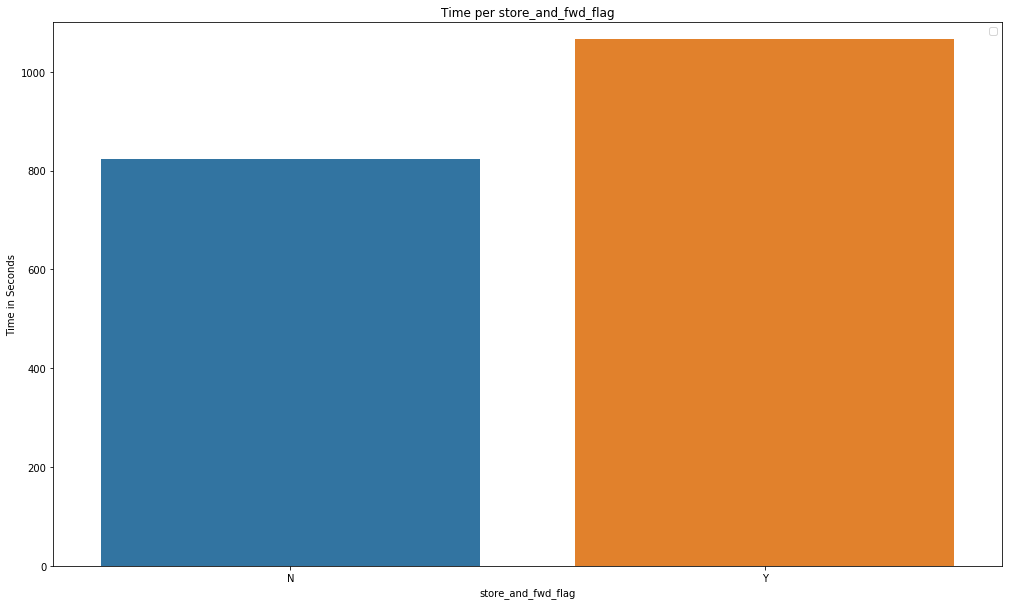

In [15]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

###### 乘客人数对乘车时间的影响

No handles with labels found to put in legend.


Text(0.5,0,'乘客人数')

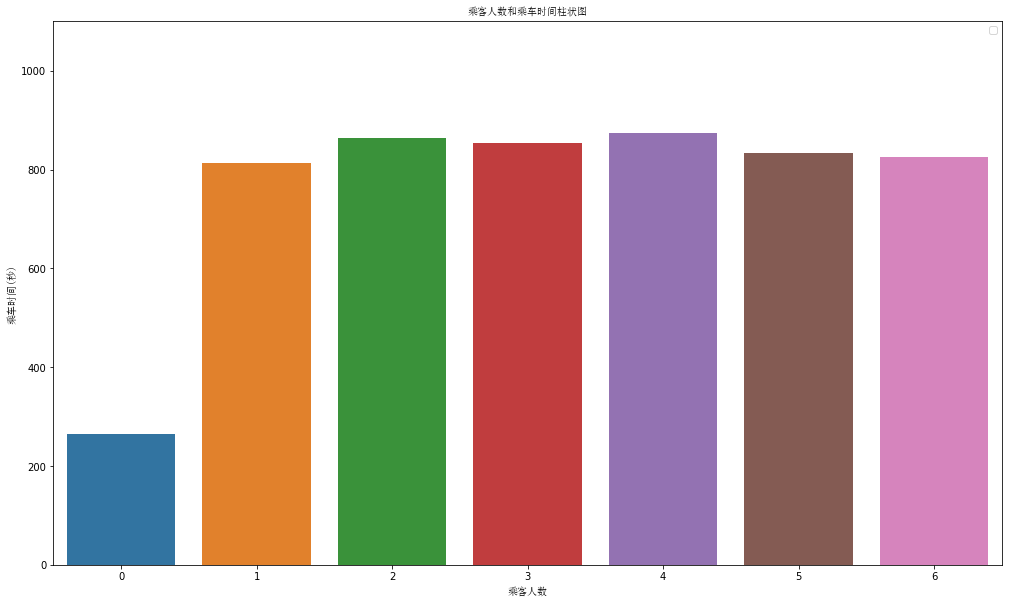

In [16]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('乘客人数和乘车时间柱状图',fontproperties=myfont)
plt.legend(loc=0)
plt.ylabel('乘车时间(秒)',fontproperties=myfont)
sns.barplot(pc.index,pc.values)
plt.xlabel('乘客人数',fontproperties=myfont)

In [17]:
#训练集乘客分布
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [18]:
#测试集乘客分布
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

## 3地图路线可视化

###### 绘制纽约城市坐标地图

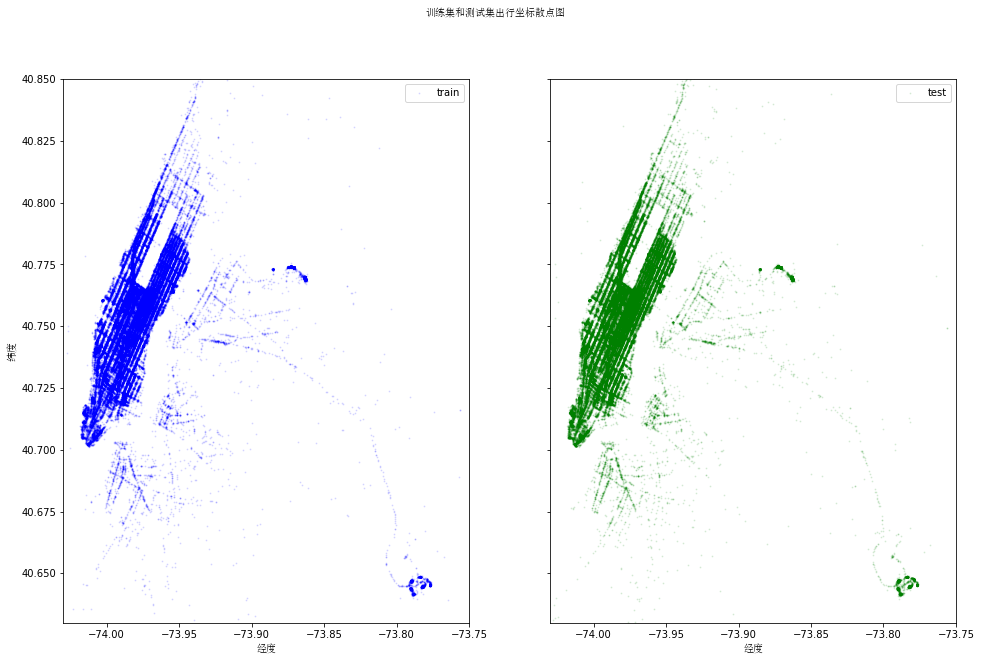

In [19]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True) #共享横纵坐标
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('训练集和测试集出行坐标散点图',fontproperties=myfont)
ax[0].legend(loc=0)
ax[0].set_ylabel('纬度',fontproperties=myfont)
ax[0].set_xlabel('经度',fontproperties=myfont)
ax[1].set_xlabel('经度',fontproperties=myfont)
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [20]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [21]:
#正弦距离
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
#旅行总距离    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
#方向
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [22]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,6.122,1.499,1.735,99.970
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,6.498,1.806,2.431,-117.154
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,7.662,6.385,8.204,-159.680
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,6.064,1.485,1.661,-172.738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,6.078,1.189,1.199,179.474


###### 分类k均值

In [23]:
#数组拼接，按行顺序
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [24]:
sample_ind = np.random.permutation(len(coords))[:500000] #产生随机数
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [25]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

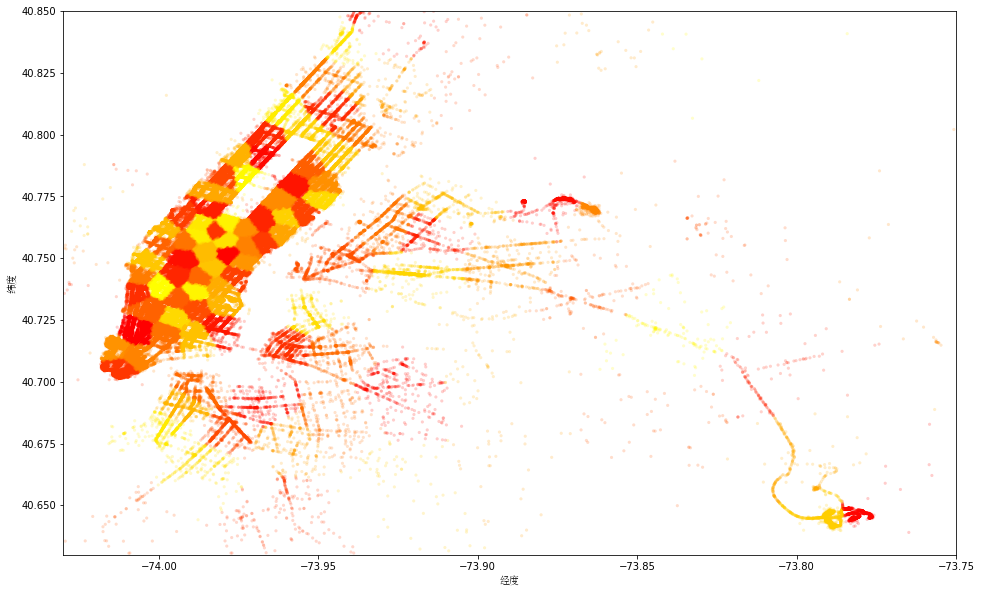

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('经度',fontproperties = myfont)
ax.set_ylabel('纬度',fontproperties = myfont)
plt.show()

###### 数据抽取

In [27]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [28]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [29]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

###### month和day和week作为虚拟变量

In [30]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

In [31]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

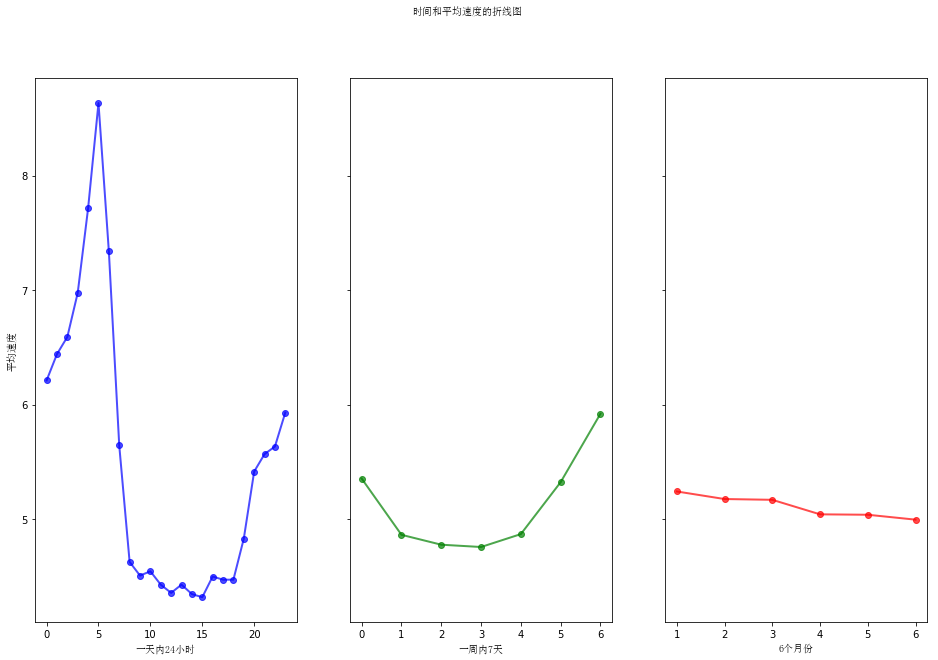

In [32]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_m'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_m'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_m'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('一天内24小时',fontproperties=myfont)
ax[1].set_xlabel('一周内7天',fontproperties=myfont)
ax[2].set_xlabel('6个月份',fontproperties=myfont)
ax[0].set_ylabel('平均速度',fontproperties=myfont)
fig.suptitle('时间和平均速度的折线图',fontproperties=myfont)
plt.show()

###### 绘制平均速度

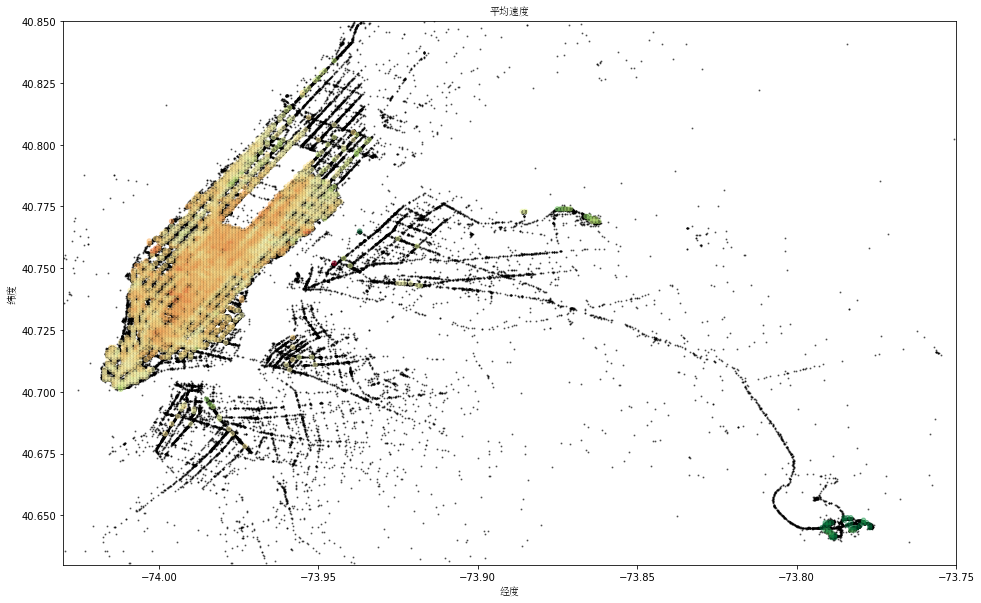

In [33]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']

coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()#根据坐标分组，求出平均速度
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()#根据坐标分组，求出个数
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('经度',fontproperties=myfont)
ax.set_ylabel('纬度',fontproperties=myfont)
plt.title('平均速度',fontproperties=myfont)
plt.show()

In [34]:
coord_stats

,pickup_lat_bin,pickup_long_bin,avg_speed_h,id
163,40.641,-73.789,7.482,236
164,40.641,-73.788,7.772,414
185,40.642,-73.789,7.254,478
186,40.642,-73.788,7.757,803
213,40.643,-73.790,6.675,481
214,40.643,-73.789,7.014,232
244,40.644,-73.791,6.975,274
245,40.644,-73.790,7.194,2300
252,40.644,-73.783,6.643,464
253,40.644,-73.782,6.857,399


## 4数据丰富和虚拟变量

##### 数据丰富

In [35]:

vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [36]:
vendor_train.shape,vendor_test.shape

((1437128, 2), (625134, 2))

In [37]:
passenger_count_train.shape,passenger_count_test.shape

((1437128, 7), (625134, 8))

In [38]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

((1437128, 2), (625134, 2))

In [39]:
cluster_pickup_train.shape,cluster_pickup_test.shape

((1437128, 100), (625134, 100))

In [40]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

((1437128, 100), (625134, 100))

In [41]:
month_train.shape,month_test.shape

((1437128, 6), (625134, 6))

In [42]:
dom_train.shape,dom_test.shape

((1437128, 31), (625134, 31))

In [43]:
hour_train.shape,hour_test.shape

((1437128, 24), (625134, 24))

In [44]:
dow_train.shape,dow_test.shape

((1437128, 7), (625134, 7))

In [45]:
#去除乘客人数为9人的异常值（实际删除虚拟变量）
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [46]:
#删除之前添加的分类变量
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [47]:
train.shape,test.shape

((1437128, 8), (625134, 7))

In [48]:
#添加变量
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [49]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [50]:
Train_Master.shape,Test_master.shape

((1437128, 287), (625134, 286))

In [51]:
#可以删除
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [52]:
Train_Master.shape,Test_master.shape

((1437128, 285), (625134, 284))

In [53]:
Train_Master.head()

,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,vi_1,vi_2,pc_0,pc_1,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,6.122,1.499,1.735,99.970,11,14,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,6.498,1.806,2.431,-117.154,67,38,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,7.662,6.385,8.204,-159.680,94,51,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,6.064,1.485,1.661,-172.738,0,21,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,6.078,1.189,1.199,179.474,69,97,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [54]:
Test_master.head()

,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,vi_1,vi_2,pc_0,pc_1,pc_2,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2.746,2.913,-3.595,30,45,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,2.759,3.105,172.279,62,22,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,1.306,1.846,133.326,99,30,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,5.269,7.163,-150.957,26,30,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,0.961,1.354,130.260,55,64,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [55]:
#划分训练测试集
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [56]:
Train.shape

(80000, 285)

In [57]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

#删除取对数的那列
Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [58]:
#转化为Xgboost支持的数据格式
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

## 训练模型和测试准确性

In [59]:
#md = [6]
#lr = [0.1,0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            t0 = datetime.now()
#            xgb_pars = {'min_child_weight': mcw, 'eta': lr, 'colsample_bytree': 0.9, 
#                        'max_depth': md,
#            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
#                  maximize=False, verbose_eval=1)

In [60]:
#调参 eta:过拟合 max_depth:树的最大深度(越深可能会过拟合) min_child_weight：叶子节点最小权重（低于此，就会停止划分）
# subsample：训练子集的子样本比例（防止过拟合）colsample_bytree：对每一个生成的树进行二次采样 lambda：L2正则化（防止过拟合）
# nthread:并行运行算法的线程数 booster:助推器 gbtree  silent：不反馈消息
# eval_metric：评估指标(rmse:根的均方误差)
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 'max_depth': 6,'subsample': 0.9, 'lambda': 1.,
            'nthread': -1, 'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score) # 均方根误差

[18:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[18:10:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.02606	valid-rmse:3.02735
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.56283	valid-rmse:1.56293
[2]	train-rmse:0.86754	valid-rmse:0.86928
[3]	train-rmse:0.57167	valid-rmse:0.57550
[4]	train-rmse:0.46580	valid-rmse:0.47270
[5]	train-rmse:0.42870	valid-rmse:0.43922
[6]	train-rmse:0.41535	valid-rmse:0.42797
[

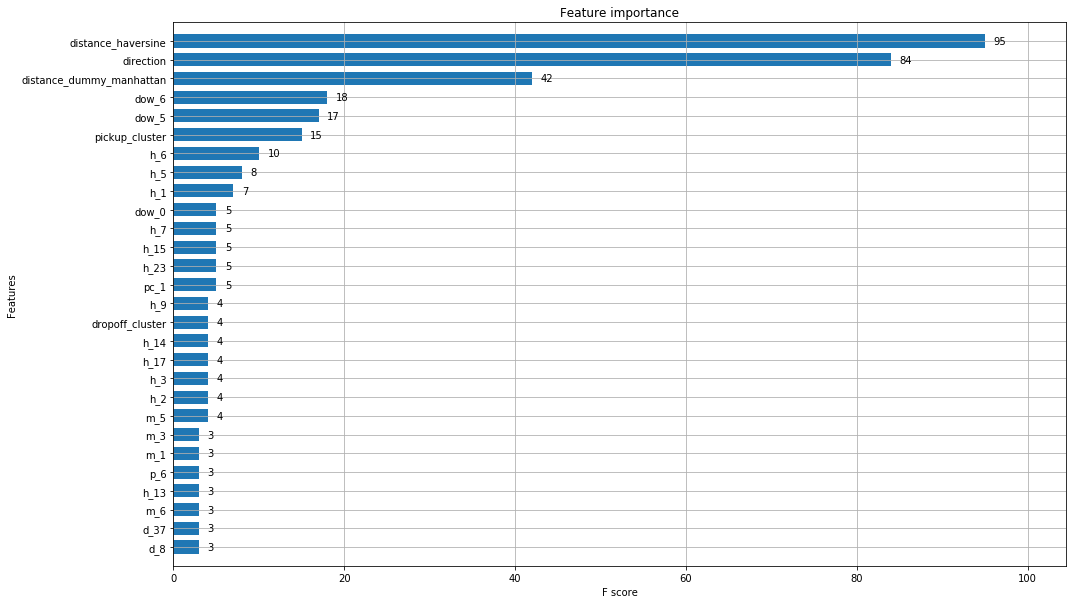

In [61]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

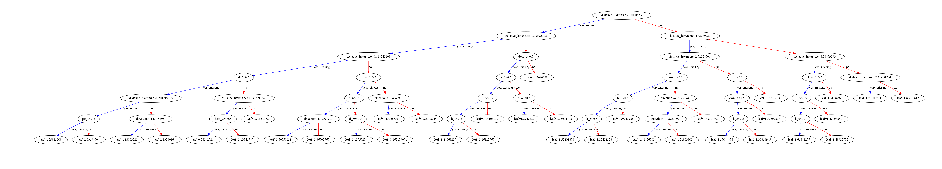

In [82]:
clf=xgb.plot_tree(model, num_trees=1)

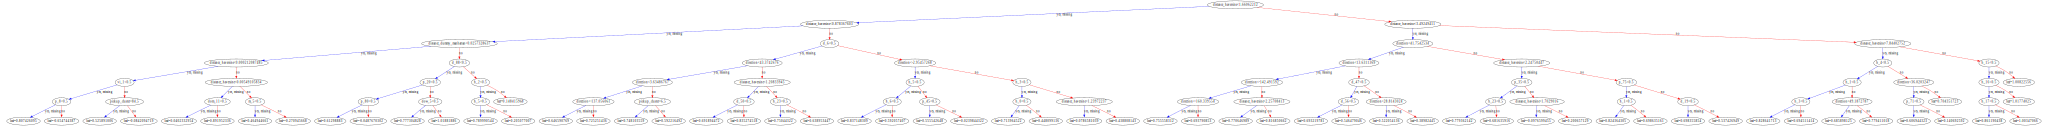

In [84]:
xgb.to_graphviz(model, num_trees=2)

In [138]:
#预测
pred = model.predict(dtest)
pred = np.exp(pred) - 1

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [137]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

array([ 930.00494,  825.0043 ,  439.80267, ..., 1319.692  , 1588.8654 ,
        884.3745 ], dtype=float32)